In [1]:
import re

import pandas as pd
from pathlib import Path
from ploting import *

In [2]:
root_path = "perlmutter"

In [3]:
name_re = re.compile("(weak|strong)_scaling-d_(\d+)-n_(\d+)-([\w_]+)_comm-(gpu|cpu)-nodes_(\d+)")

In [4]:
time_re = re.compile("DURATION:\s*(\d+(\.\d+)?(e[+-]\d+)?)")

In [5]:
data = []
for file in Path(f"{root_path}/data").iterdir():
    if m := name_re.search(file.name):
        with open(file, "r") as input:
            if t_m := time_re.search(input.read()):
                duration = t_m.group(1)
                data.append({"scaling": m.group(1), "dim": m.group(2), "n": m.group(3), "comm_pattern": m.group(4),
                             "type": m.group(5), "nodes": m.group(6), "time": duration})
df = pd.DataFrame(data).drop(columns=["scaling", "type"]).astype({"dim": int, "n": int, "nodes": int, "time": float})
df

,dim,n,comm_pattern,nodes,time
0,2,100000,stencil,16,0.000161
1,2,100,stencil,128,0.000187
2,2,100000,stencil,128,0.000155
3,2,100,stencil,16,0.000183
4,3,100,stencil,2,0.000162
...,...,...,...,...,...
154,3,1000000,neighborhood,2,0.000683
155,3,1000000,neighborhood,32,0.000788
156,3,1000000,neighborhood,4,0.000693
157,3,1000000,neighborhood,64,0.000802


In [7]:
piv = df.pivot(index="nodes", columns=["dim", "comm_pattern", "n"], values="time")
piv = piv[piv.columns.sort_values()]
piv

dim                     2                                                    \
comm_pattern neighborhood                                           stencil   
n                 100       1000      10000     100000    1000000   100       
nodes                                                                         
1                0.000075  0.000075  0.000070  0.000067  0.000310  0.000085   
2                0.000113  0.000114  0.000108  0.000102  0.000339  0.000125   
4                0.000168  0.000169  0.000146  0.000138  0.000361  0.000179   
8                0.000169  0.000169  0.000146  0.000137  0.000350  0.000181   
16               0.000171  0.000169  0.000149  0.000142  0.000351  0.000183   
32               0.000185  0.000189  0.000149  0.000140  0.000359  0.000184   
64               0.000177  0.000179  0.000149  0.000130  0.000355  0.000188   
128              0.000172  0.000176  0.000149  0.000146  0.000359  0.000187   

dim                                                             3            \
comm_pattern                                         neighborhood             
n              1000      10000     100000    1000000      100       1000      
nodes                                                                         
1             0.000084  0.000083  0.000083  0.000322     0.000075  0.000062   
2             0.000125  0.000123  0.000117  0.000357     0.000150  0.000139   
4             0.000179  0.000158  0.000155  0.000365     0.000223  0.000195   
8             0.000180  0.000162  0.000156  0.000366     0.000333  0.000291   
16            0.000183  0.000164  0.000161  0.000371     0.000494  0.000440   
32            0.000184  0.000170  0.000161  0.000376     0.000500  0.000441   
64            0.000190  0.000174  0.000157  0.000382     0.000524  0.000476   
128           0.000191  0.000175  0.000155  0.000384          NaN  0.000487   

dim                                                                       \
comm_pattern                                 stencil                       
n              10000     100000    1000000   100       1000      10000     
nodes                                                                      
1             0.000061  0.000110  0.000567  0.000084  0.000069  0.000074   
2             0.000119  0.000150  0.000683  0.000162  0.000154  0.000131   
4             0.000190  0.000203  0.000693  0.000237  0.000208  0.000205   
8             0.000282  0.000338  0.000724  0.000345  0.000306  0.000294   
16            0.000424  0.000483  0.000785  0.000509  0.000458  0.000444   
32            0.000427  0.000486  0.000788  0.000514  0.000462  0.000449   
64            0.000444  0.000492  0.000802  0.000515  0.000471  0.000457   
128           0.000434  0.000486  0.000827  0.000533  0.000480  0.000470   

dim                               
comm_pattern                      
n              100000    1000000  
nodes                             
1             0.000125  0.000597  
2             0.000172  0.000732  
4             0.000229  0.000704  
8             0.000355  0.000736  
16            0.000506  0.000814  
32            0.000508  0.000820  
64            0.000489  0.000906  
128           0.000509  0.000970

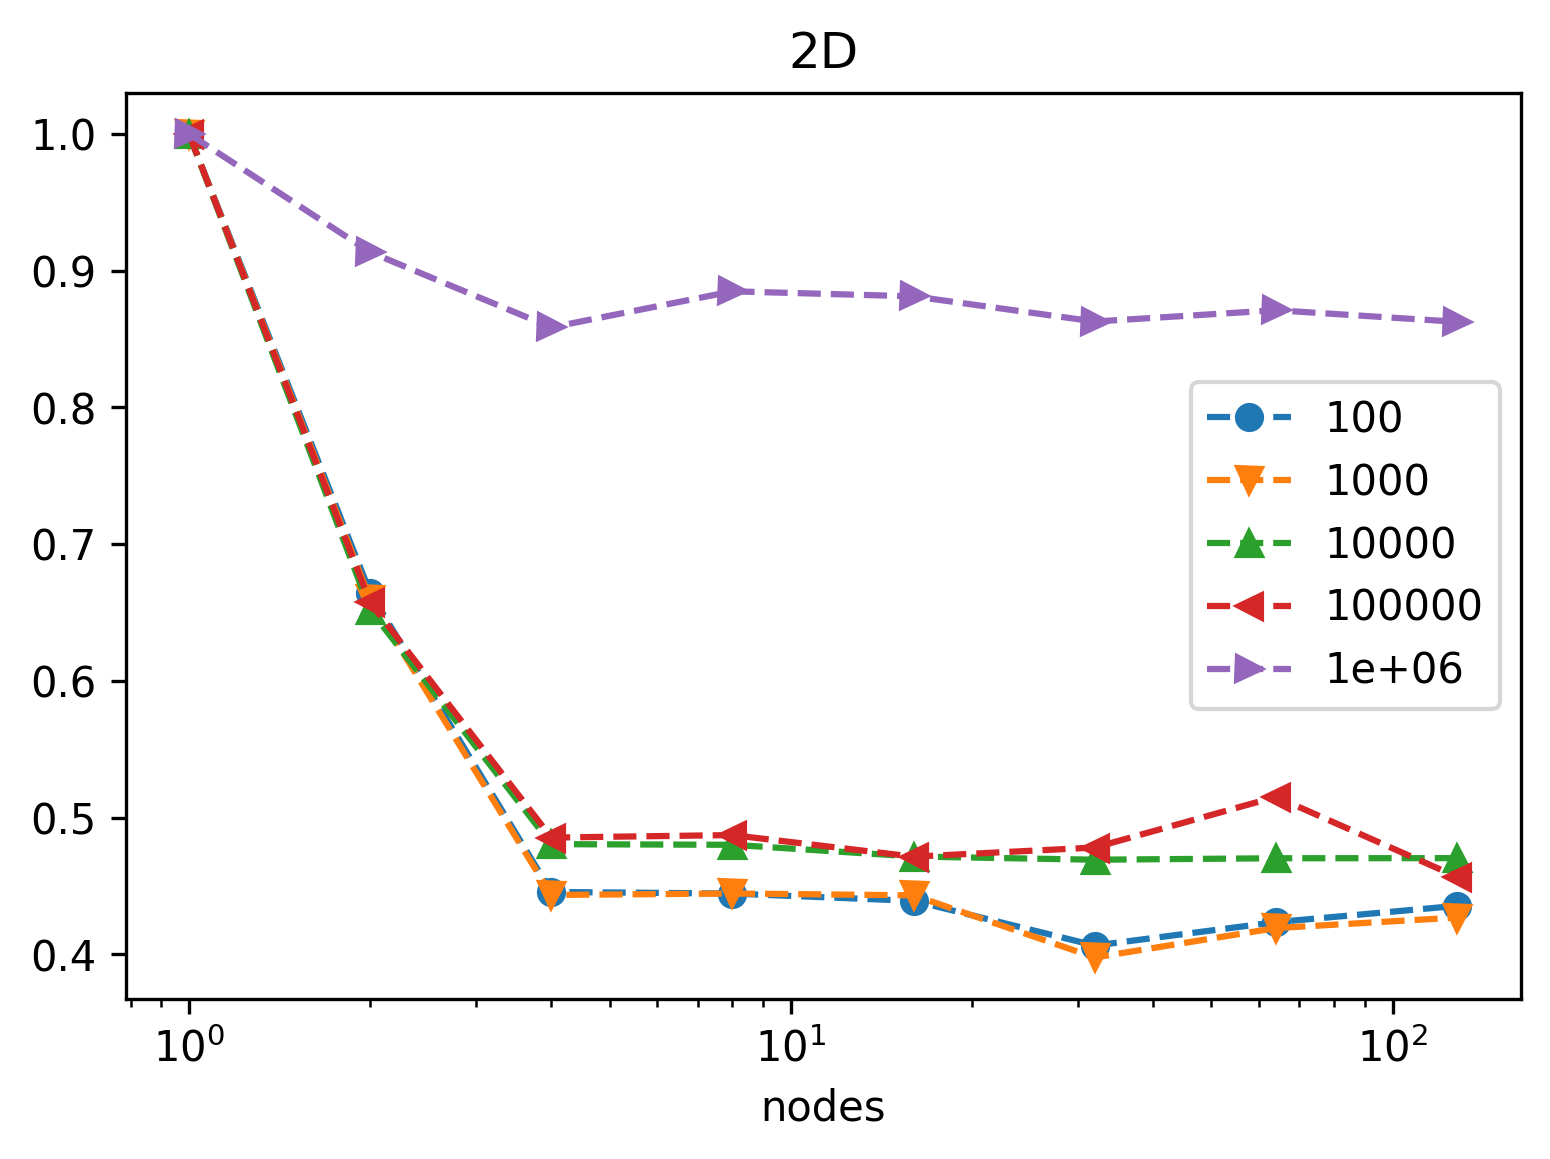

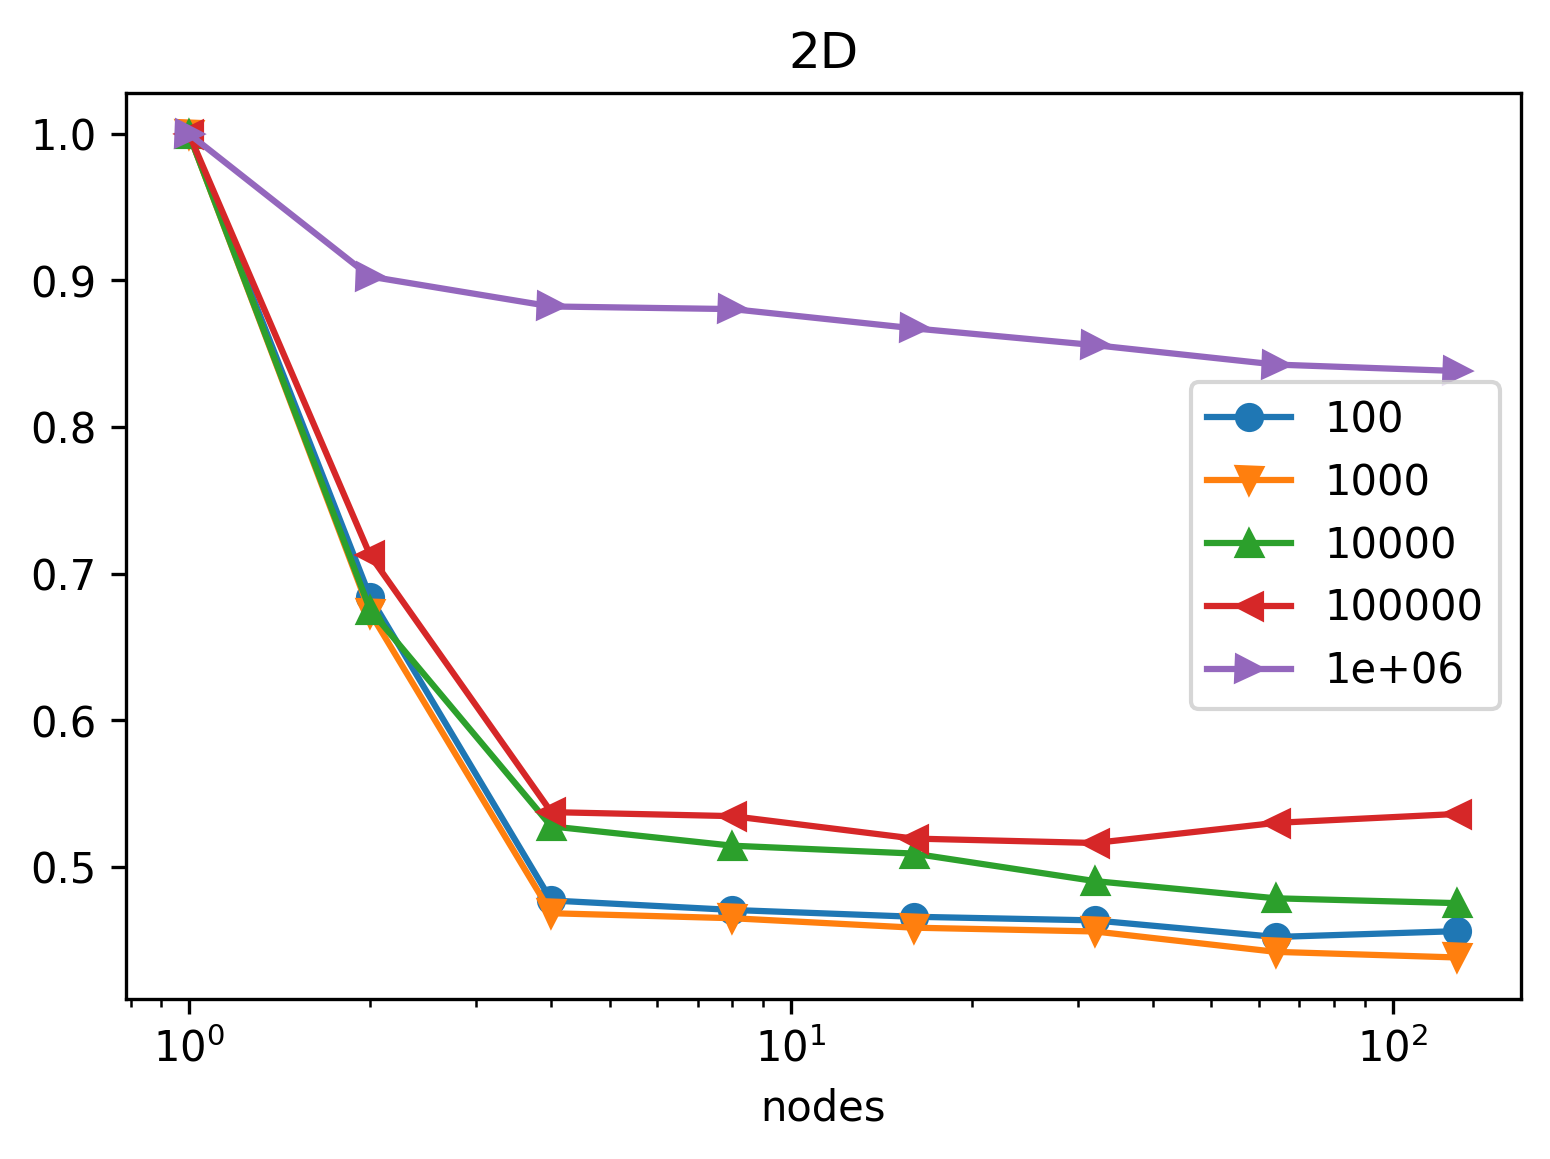

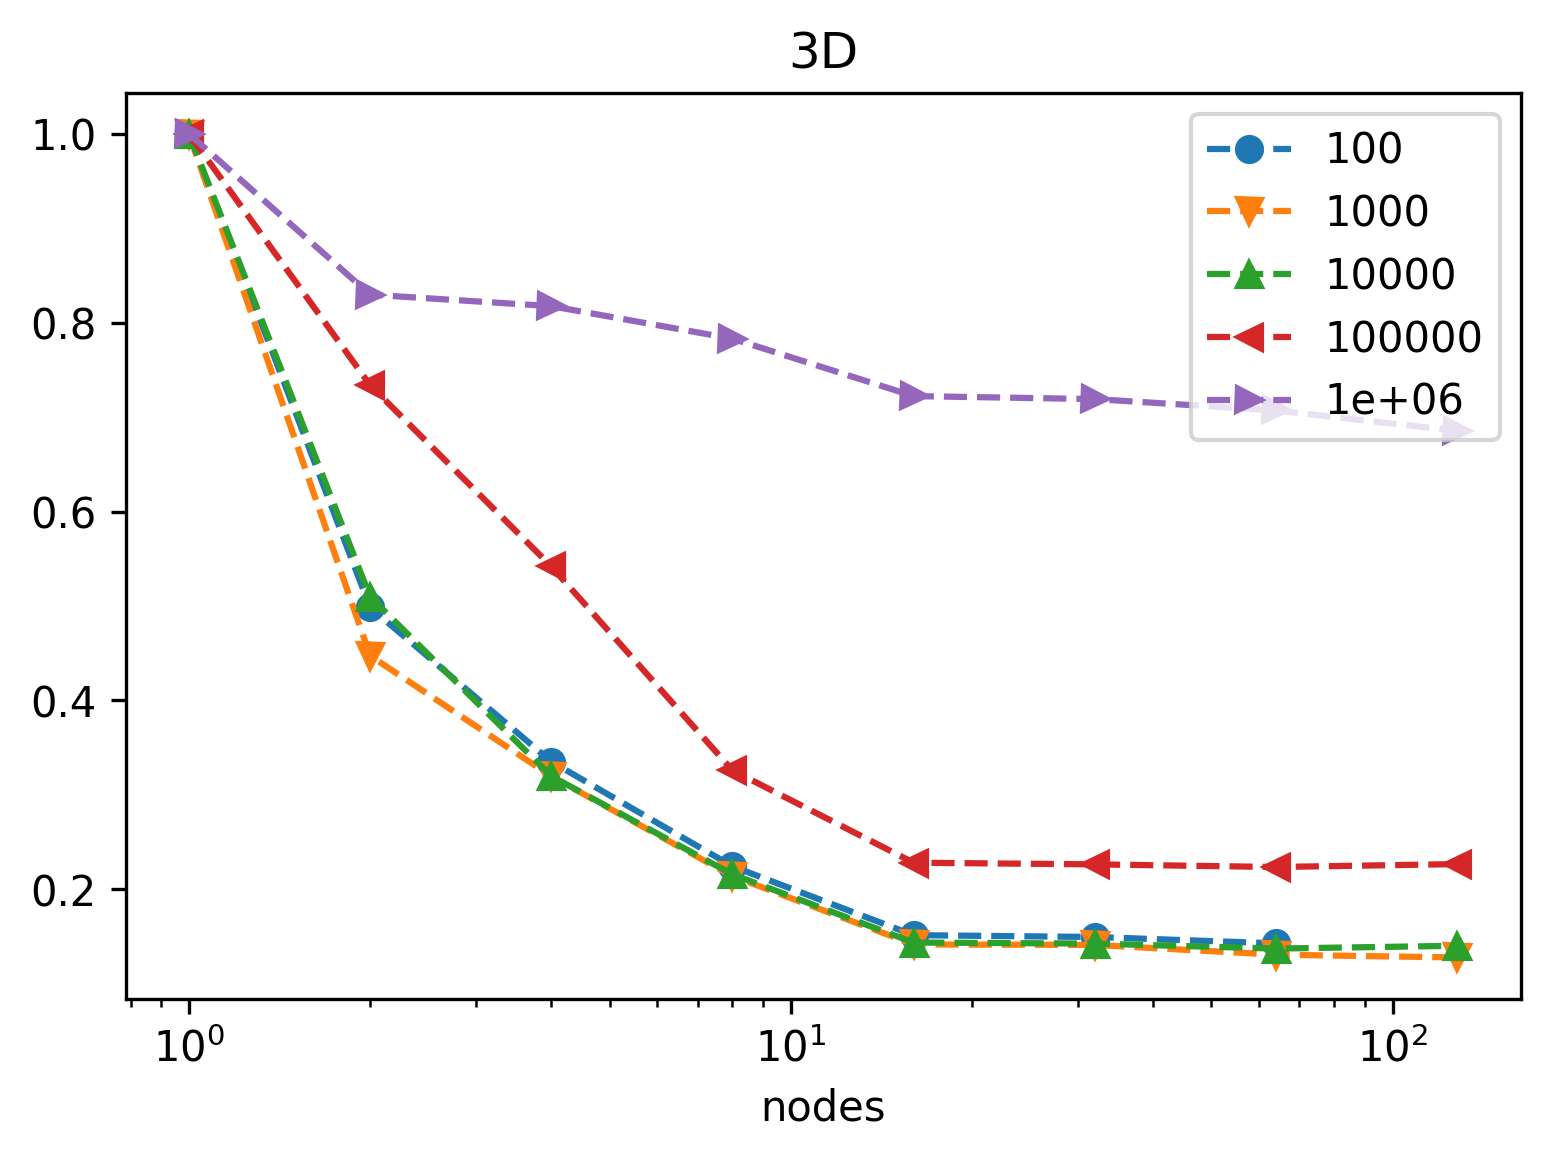

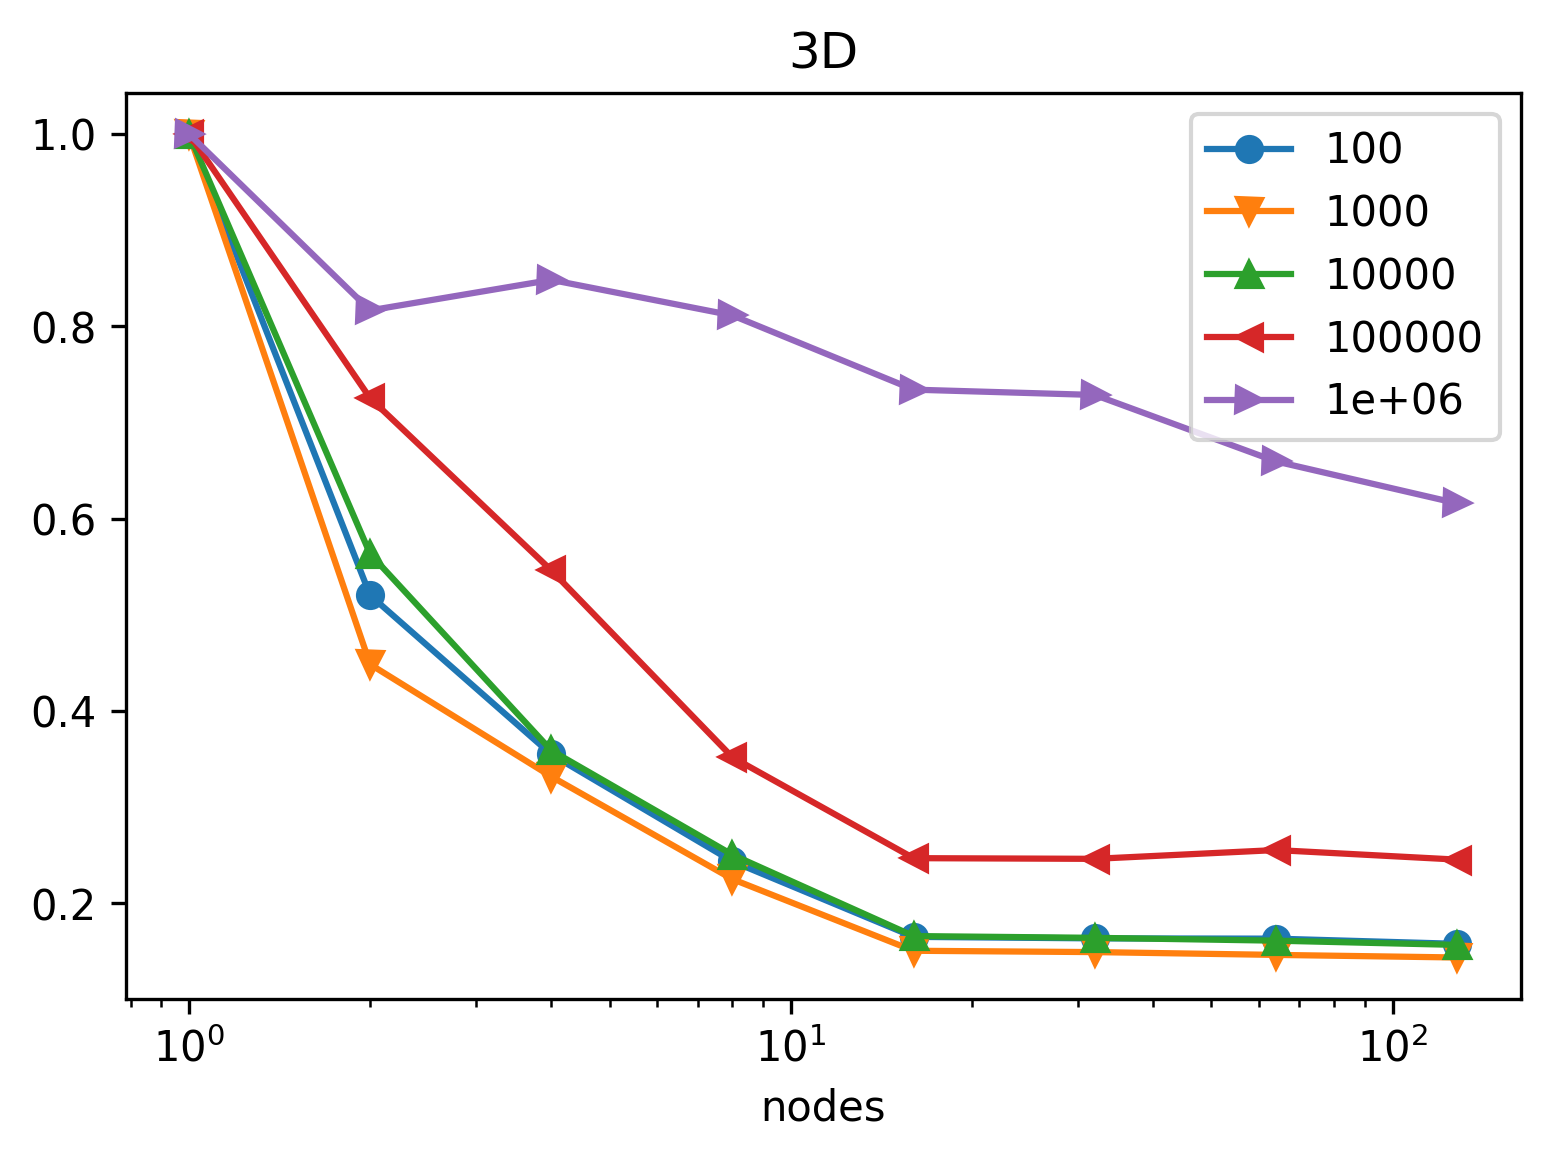

In [9]:
for dim in piv.columns.levels[0]:
    _df = piv[dim]
    for gc in piv.columns.levels[1]:
        fig, ax = plt.subplots(dpi=300)
        ax.set_prop_cycle(default_cycler if gc == "stencil" else dashed_cylcer)
        ax.set_title(f"{dim}D")
        _df[gc].apply(lambda s: s[1] / s).plot(ax=ax, legend=False, logx=True)
        ax.legend([f"{n:g}" for n in piv.columns.levels[2]])
    #fig.savefig(f"{root_path}/img/{dim}d.png")